In [4]:
from importlib import reload

import torch
import torchaudio
import numpy as np

from wav2avatar.streaming.emformer import emformer as emf
from wav2avatar.utils import utils
reload(utils)
from wav2avatar.utils import utils

import wav2avatar.inversion.wav2ema as w2e
import wav2avatar.inversion.linear_inversion as linv

import matplotlib.pyplot as plt

In [19]:
# Emformer Import

device = 0
input_dim=512
num_heads=16
ffn_dim=512
num_layers=15
segment_length=5
left_context_length=20
right_context_length=0

emformer = emf.EMAEmformer(
    input_dim=input_dim,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    num_layers=num_layers,
    segment_length=segment_length,
    left_context_length=left_context_length
).to(device)

ckpt = torch.load(f"../../website/ckpts/emf_l{left_context_length}_r{right_context_length}_p{segment_length}_nh{num_heads}__nl{num_layers}_ffd{ffn_dim}_0.89.pth", map_location="cuda:0")

emformer.load_state_dict(ckpt["emformer_state_dict"])

<All keys matched successfully>

In [7]:
# BiGRU import

bigru = w2e.Wav2EMA(model_dir="../../../SpectrogramSynthesis/hprc_no_m1f2_h2emaph_gru_joint_nogan_model")

--- using cuda ---


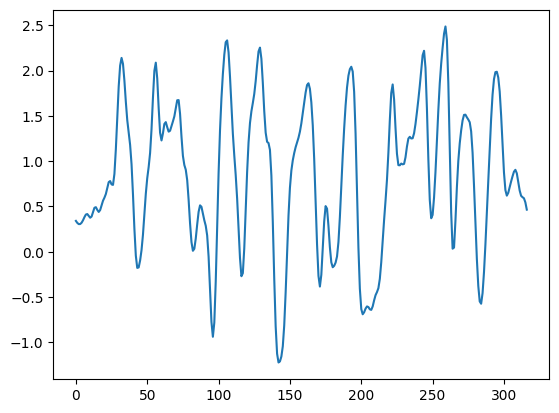

In [5]:
mng_08_audio, sr = torchaudio.load("../inversion/wav/mngu0_s1_0008.wav")
mng_ema_gt = np.load("../inversion/ema/mngu0_s1_0008.npy")
mng_ema_gt = utils.Utils.mngu0_to_hprc(mng_ema_gt)
mng_ema_gt = linv.EMADataset.downsample_by_mean(mng_ema_gt, 200 // 50)
mng_ema_gt = linv.EMADataset.butter_bandpass_filter(mng_ema_gt, 10, 50)

# Sanity Check
plt.plot(mng_ema_gt[:, 0])

In [9]:
bigru.wav_to_ema(mng_08_audio.squeeze(0).numpy()).shape

(634, 53)